### read in the data

In [1]:
import pandas as pd

raw_df = pd.read_feather("../data/data.feather") # main survey data
test_items_df = pd.read_csv("../data/test_items.csv",index_col=0) # intelligence proxy questions
question_data = pd.read_csv("../data/question_data.csv", sep=';', index_col=0) # question metadata

In [2]:
question_weights = pd.read_csv('../outputs/question_weights.csv', index_col=0) # question metadata with col for weights for questions 
q_weights = question_weights.scores.to_list()
len(q_weights)

576

In [3]:
test_item_qs = [item for item in test_items_df.index if item in raw_df.columns]

In [4]:
# filter out the non-survery categories
q_df = raw_df.drop(columns=test_item_qs)
q_df = q_df.filter(regex=r'^q\d+$')

In [5]:
# drop the lowest response q's
N_DROP = 2000
low_response = [col for col in question_data.sort_values('N').iloc[:N_DROP].index if col in q_df.columns]
q_df = q_df.drop(columns=low_response)

In [6]:
# sort by number of categories for easier manipulation later
sorted_num_levels = q_df.apply(lambda x: len(x.cat.categories)).sort_values()
q_df = q_df[sorted_num_levels.index]

In [7]:
question_data.loc[q_df.columns].to_csv('../outputs/filtered_qs.csv')

In [107]:
q_df.to_feather("../outputs/question_subset.feather")

In [10]:
# Get the number of unique levels per column
num_levels = q_df.nunique()

# Sort columns by unique levels
sorted_num_levels = num_levels.sort_values()

# Find the indices where the level count changes
level_counts = sorted_num_levels.values
diff = level_counts[1:] != level_counts[:-1]
border_indices = list(diff.nonzero()[0] + 1)  # +1 because diff is between elements

# For example, print the borders and corresponding levels
print("Border indices where level count changes:", border_indices)
print("Levels at borders:", level_counts[border_indices])

# You can use these indices to split the sorted columns into dfs as needed

Border indices where level count changes: [np.int64(252), np.int64(392)]
Levels at borders: [3 4]


In [11]:
# construct masks for test split

import numpy as np

non_nan = ~q_df.isna()
non_nan_indices = np.flatnonzero(non_nan.values)

np.random.seed(0)
TEST_SIZE = 0.2
test_size = int(len(non_nan_indices) * TEST_SIZE)
test_mask_flat = np.random.choice(non_nan_indices, size=test_size, replace=False)

test_mask = np.zeros_like(q_df.values, dtype=bool)
test_mask.flat[test_mask_flat] = True

# mask some cells that serve as our test set
df_masked = q_df.mask(test_mask)


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=True, handle_unknown='ignore'), q_df.columns),
    ],
    sparse_threshold=1.0
)

def transform_and_drop(df):
    X = preprocessor.fit_transform(df)

    # the sklearn onehot encoder doesn't have an option to not encode nans
    feature_names = preprocessor.get_feature_names_out()
    cols_to_keep = [i for i, name in enumerate(feature_names) if not name.endswith('_nan')]
    X = X[:, cols_to_keep]
    return X

X_combined = transform_and_drop(df_masked)

In [14]:
import numpy as np
from scipy import sparse

# Original mask (shape: n_users x n_original_questions)

# convert the original mask to a mask over the onehots
def expand_mask(mask):
    mask_expanded = []
    for col_idx, col in enumerate(q_df.columns):
        n_categories = len(q_df[col].cat.categories)
        # Repeat mask along a new axis (shape: n_users x n_categories)
        mask_repeated = np.repeat(mask[:, col_idx][:, np.newaxis], n_categories, axis=1)
        mask_expanded.append(mask_repeated)
        # sanity check
        assert mask_repeated.shape[0] == 68371

    # Stack horizontally (shape: n_users x n_encoded_features)
    mask_expanded = np.hstack(mask_expanded)
    return mask_expanded

# Convert to sparse matrix (if X_combined is sparse)
test_mask_expanded = expand_mask(test_mask)
test_mask_sparse = sparse.csr_matrix(test_mask_expanded)

original_mask = expand_mask(non_nan.values)

In [15]:
# sanity check

print(test_mask_sparse.shape, X_combined.shape)
X_combined[test_mask_sparse.nonzero()].any()

(68371, 1660) (68371, 1660)


np.False_

In [16]:
# expand loss weights:

def expand_loss_weights(weights):
    weights_expanded = []
    for col_idx, col in enumerate(q_df.columns):
        n_categories = len(q_df[col].cat.categories)
        # Repeat mask along a new axis (shape: n_users x n_categories)
        weights_expanded += ([weights[col_idx]] * n_categories)
        # sanity check
    assert len(weights_expanded) == 1660
    return weights_expanded

weights_expanded = expand_loss_weights(q_weights)
_, test_mask_qs = np.nonzero(test_mask_expanded)
loss_weights_test = np.array(weights_expanded)[test_mask_qs]
loss_weights_test.shape

(10444820,)

### data cleaned, ready for naive bayes

In [17]:
pr_q_answered = df_masked.notna().mean()
pr_user_answered = df_masked.notna().mean(axis=1)

In [18]:
feature_names = preprocessor.get_feature_names_out()

In [19]:
feature_names = preprocessor.get_feature_names_out()
kept_features = [item[8:].split('_') for item in feature_names if not item.endswith('_nan')]

In [20]:
# demonstration of how the naive imputation model works

for user, feature in zip(*test_mask_sparse.nonzero()):
    question, option = kept_features[feature]
    print(user, question, option)
    print("pr(user answers)=", pr_user_answered[user])
    print("pr(question gets answered)=", pr_q_answered[question])
    print("pr(option i selected | question K gets answered)=", df_masked[question].value_counts(normalize=True)[option])
    print("take the prodcut of these")
    break

0 q44639 No
pr(user answers)= 0.3177083333333333
pr(question gets answered)= 0.6423483640724869
pr(option i selected | question K gets answered)= 0.38171137119176646
take the prodcut of these


In [21]:
questions = np.array([q for q, o in kept_features])
options   = np.array([o for q, o in kept_features])

option_probs = {
    q: df_masked[q].value_counts(normalize=True).reindex(q_df[q].cat.categories, fill_value=0)
    for q in q_df.columns
}
option_probs_df = pd.DataFrame(option_probs).T  # index: question, columns: option. super redundant but helps vectorize the operations below

users_idx, features_idx = test_mask_sparse.nonzero()

q_for_masked = questions[features_idx]
o_for_masked = options[features_idx]

pr_user_vals = pr_user_answered.values[users_idx]
pr_q_vals    = pr_q_answered[q_for_masked].values
pr_option_vals = option_probs_df.values[
    option_probs_df.index.get_indexer(q_for_masked),
    option_probs_df.columns.get_indexer(o_for_masked)
]

# Vectorized naive bayes
naive_imputed_values = pr_user_vals * pr_q_vals * pr_option_vals


In [22]:
# compare hidden test values to real values
X_not_masked = transform_and_drop(q_df)

# check:
X_not_masked.shape == X_combined.shape

True

In [23]:
(np.asarray(X_not_masked[test_mask_sparse] - naive_imputed_values).ravel()**2).shape

(10444820,)

In [24]:
# MSE
mse_naive = np.average(np.asarray(X_not_masked[test_mask_sparse] - naive_imputed_values).ravel()**2, weights=loss_weights_test)
mse_naive

np.float64(0.27249386668583225)

In [25]:
# this is the one that Yoram explained to me, but I think the one above makes more sense.

row_mean = X_combined.mean(axis=1).ravel()
col_mean = X_combined.mean(axis=0).ravel()

naive_imputation2 = np.asarray(row_mean).ravel()[users_idx] * np.asarray(col_mean).ravel()[features_idx]

mse_naive2 = np.average(np.asarray(X_not_masked[test_mask_sparse] - naive_imputation2).ravel()**2, weights=loss_weights_test)
mse_naive2

np.float64(0.31765224077267906)

### imputing values randomly

In [26]:
# random
mse_random = np.average(np.asarray(X_not_masked[test_mask_sparse] - np.random.uniform(size=naive_imputed_values.shape)).ravel() **2, weights=loss_weights_test)
mse_random

np.float64(0.3333067725592099)

In [27]:
# impute as as constant, mean of test data:

train_data = X_not_masked[original_mask & ~test_mask_sparse.toarray()]
mean_val = train_data.mean()

mse_constant = np.average(np.asarray(X_not_masked[test_mask_sparse] - (np.zeros_like(naive_imputed_values) + mean_val)).ravel() **2, weights=loss_weights_test)
mse_constant

np.float64(0.22617873756601115)

### imputing as modal answer

In [28]:
def get_mode(series):
    return series.mode().iloc[0]

df_modal_imputed = df_masked.apply(lambda col: col.fillna(get_mode(col)))
X_modal = transform_and_drop(df_modal_imputed)

In [29]:
# MSE
mse_modal = np.average(np.asarray(X_not_masked[test_mask_sparse] - X_modal[test_mask_sparse]).ravel() **2, weights=loss_weights_test)
mse_modal

np.float64(0.2552871884444088)

### low rank approximation method!

In [30]:
import torch
import torch.optim as optim
import torch.nn.functional as F

def torch_avg(tensor, weights):
    assert tensor.shape == weights.shape
    return torch.sum(tensor * weights) / torch.sum(weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [54]:
# Convert sparse matrices to PyTorch tensors
X_combined_tensor = torch.tensor(X_combined.toarray(), dtype=torch.float32).to(device)
test_mask_tensor = torch.tensor(test_mask_sparse.toarray(), dtype=torch.bool).to(device)
train_mask_tensor = torch.tensor(original_mask, dtype=torch.bool).to(device) & ~test_mask_tensor

train_mask_qs = torch.nonzero(train_mask_tensor)[:,1]
loss_weights_train = torch.tensor(weights_expanded)[train_mask_qs.cpu()].to(device)
loss_weights_test_tensor = torch.from_numpy(loss_weights_test).to(device)

test_values_tensor = torch.from_numpy(X_not_masked[test_mask_sparse]).to(device)

In [86]:
from tqdm import tqdm, trange

# Hyperparameters
rank = 5  # Rank of the approximation (adjust as needed)
learning_rate = 0.2
epochs = 50

# Initialize low-rank matrices B and C
n_users, n_features = X_combined.shape
B = torch.randn(n_users, rank, requires_grad=True, device=device)
C = torch.randn(rank, n_features, requires_grad=True, device=device)
X_hat = torch.mm(B, C)

# Optimizer
optimizer = optim.Adam([B, C], lr=learning_rate)

@torch.compile
def split_and_softmax(X):
    split_sizes = [border_indices[0]] + \
                [border_indices[i+1] - border_indices[i] for i in range(len(border_indices)-1)] + \
                [q_df.shape[1] - border_indices[-1]]

    split_sizes = [item * (i+2) for i, item in enumerate(split_sizes)]
    split_tensors = torch.split(X, split_sizes, dim=1)

    processed_tensors = []
    for i, tensor in enumerate(split_tensors):
        options_per_question = 2 + i  # 2 for first split, 3 for second, 4 for third
        n_questions = tensor.shape[1] // options_per_question
        
        # Reshape to (n_users, n_questions, options_per_question)
        reshaped = tensor.view(-1, n_questions, options_per_question)
        
        # Apply softmax along the last dimension
        softmaxed = F.softmax(reshaped, dim=-1)
        processed_tensors.append(softmaxed)
    
    flattened_tensors = [tensor.view(tensor.shape[0], -1) for tensor in processed_tensors]
    X_softmaxed = torch.cat(flattened_tensors, dim=1)
    return X_softmaxed

def get_test_loss(X_hat):
    X_imputed = X_hat

    # Evaluate on test set
    imputed_test_values = X_imputed[test_mask_tensor]
    mse_low_rank = torch_avg(((test_values_tensor - imputed_test_values) ** 2).ravel(), loss_weights_test_tensor)
    return mse_low_rank.item()

# Training loop
def train_loop():
    train_losses = []
    test_losses = []
    for epoch in trange(epochs):
        optimizer.zero_grad()
        
        # Reconstruct X_hat = B @ C
        X_hat = torch.mm(B, C)
        X_hat = split_and_softmax(X_hat) # this is the right inductive bias and it also dratically lowers the loss

        # Compute loss only on observed entries (not masked for testing)
        loss = torch_avg((X_hat[train_mask_tensor] - X_combined_tensor[train_mask_tensor]) ** 2, weights=loss_weights_train)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        test_losses.append(get_test_loss(X_hat))
        # print(f"Epoch {epoch}, Loss: {loss.item()}")
    return X_hat, train_losses, test_losses

X_hat, train_losses, test_losses = train_loop()

100%|██████████| 50/50 [00:05<00:00, 10.00it/s]


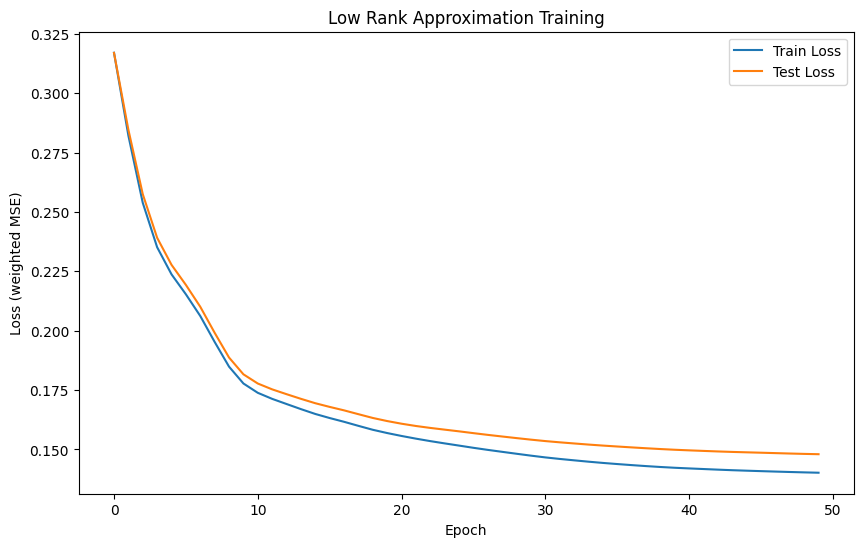

In [87]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (weighted MSE)')
plt.title('Low Rank Approximation Training')
plt.legend()
plt.savefig('../outputs/lora_loss.pdf')
plt.show()

In [88]:
mse_low_rank = get_test_loss(X_hat)
print(f"Low-rank MSE: {mse_low_rank}")

Low-rank MSE: 0.1480188535867763


### autoencoder without minibatching

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Hyperparameters
input_dim = X_combined_tensor.shape[1]
encoding_dim = 5
learning_rate = 0.001
epochs = 50

# Create the autoencoder model
model = Autoencoder(input_dim, encoding_dim).to(device)

# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses_ae=[]
test_losses_ae=[]
for epoch in trange(epochs):
    optimizer.zero_grad()
    # Forward pass
    outputs = model(X_combined_tensor)
    outputs_softmax = split_and_softmax(outputs)
    
    loss = torch_avg((outputs_softmax[train_mask_tensor] - X_combined_tensor[train_mask_tensor]) ** 2, weights=loss_weights_train)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    test_loss = get_test_loss(outputs_softmax)
    train_losses_ae.append(loss.item())
    test_losses_ae.append(test_loss)
    
    
# Use the trained model for imputation
model.eval()
with torch.no_grad():
    imputed_data = model(X_combined_tensor)
    imputed_data_softmax = split_and_softmax(imputed_data)

mse_autoencoder = get_test_loss(imputed_data_softmax)
print(f"Autoencoder MSE: {mse_autoencoder}")

100%|██████████| 50/50 [00:07<00:00,  6.67it/s]

Autoencoder MSE: 0.1510528948938642


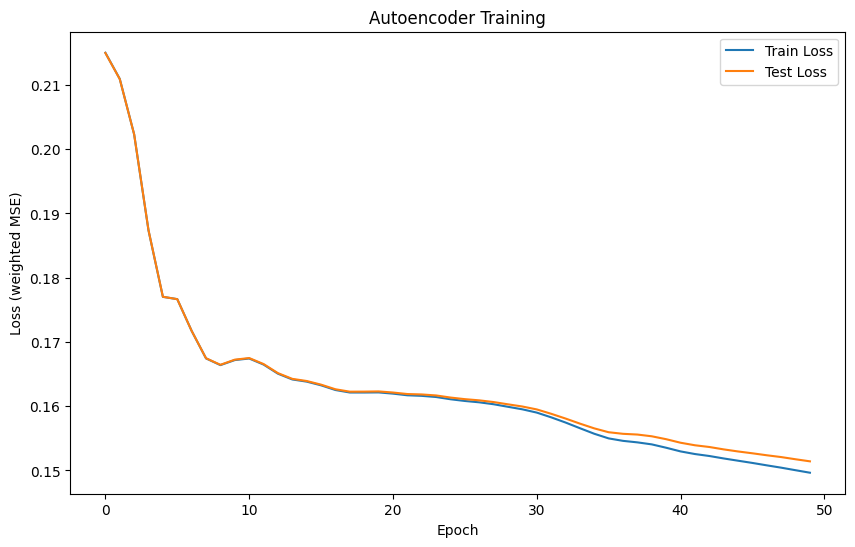

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_ae, label='Train Loss')
plt.plot(test_losses_ae, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (weighted MSE)')
plt.title('Autoencoder Training')
plt.legend()
plt.savefig('../outputs/ae_loss.pdf')
plt.show()

### compare MSE's

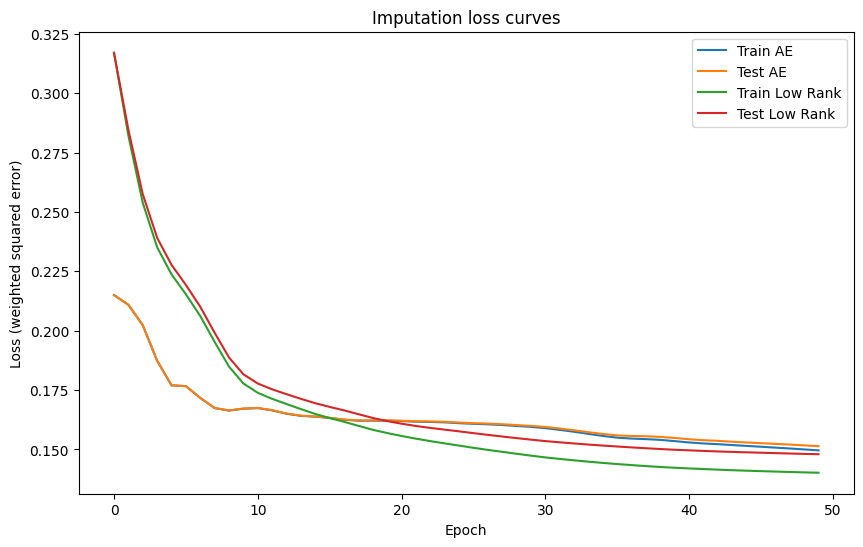

In [208]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_ae, label='Train AE')
plt.plot(test_losses_ae, label='Test AE')
plt.plot(train_losses, label='Train Low Rank')
plt.plot(test_losses, label='Test Low Rank')
plt.xlabel('Epoch')
plt.ylabel('Loss (weighted squared error)')
plt.title('Imputation loss curves')
plt.legend()
plt.savefig('../outputs/compare_loss.pdf')
plt.show()

/tmp/ipykernel_16433/1667758566.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=e_series.index, y=e_series.values, palette='viridis')


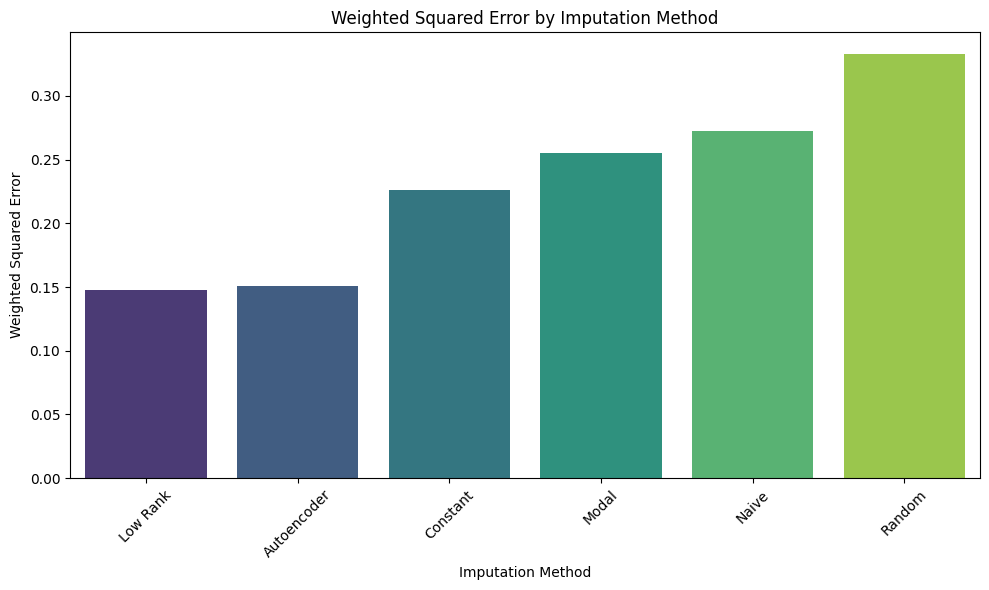

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

errors = {"Autoencoder": mse_autoencoder,
'Constant': mse_constant,
'Low Rank': mse_low_rank,
'Modal': mse_modal,
'Naive': mse_naive,
# 'naive2': mse_naive2,
'Random': mse_random}

e_series = pd.Series(errors).sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=e_series.index, y=e_series.values, palette='viridis')
plt.title('Weighted Squared Error by Imputation Method')
plt.xlabel('Imputation Method')
plt.ylabel('Weighted Squared Error')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../outputs/imputers.pdf')

plt.show()

### save the low rank imputation

In [101]:
imputed_onehot = X_hat.detach().cpu().numpy()
np.save('../outputs/imputed_lora.npy', imputed_onehot)

In [253]:
# imputed_onehot
# original_mask
# X_combined

original = X_combined.toarray().copy()
original[~original_mask] = imputed_onehot[~original_mask]
np.save('../outputs/imputed_with_original.npy', original)

In [103]:
with_indicators = np.concatenate([imputed_onehot, q_df.isna().values], axis=1)
np.save('../outputs/imputed_lora_indicators.npy', with_indicators)

In [254]:
with_indicators_original = np.concatenate([original, q_df.isna().values], axis=1)
np.save('../outputs/imputed_lora_indicators_original.npy', with_indicators_original)

### feature importance

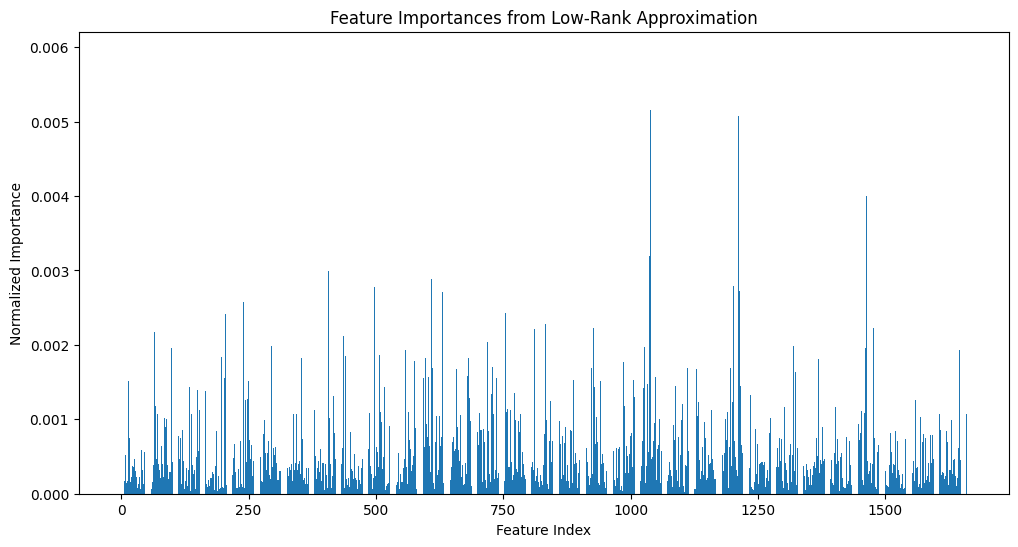

In [135]:
# Compute feature importance
feature_importance = (C.detach() ** 2).sum(dim=0).cpu().numpy()  # Sum squared weights
feature_importance /= feature_importance.sum()  # Normalize


# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Normalized Importance')
plt.title('Feature Importances from Low-Rank Approximation')
plt.show()



In [129]:
pairs = []
for col in q_df.columns:
    cats = q_df[col].cat.categories
    pairs.extend((col, cat) for cat in cats)

multi_index = pd.MultiIndex.from_tuples(pairs, names=["Column", "Category"])

In [165]:
triples = []
for pair, importance in zip(pairs, feature_importance.tolist()):
    triples.append((pair[0], pair[1], importance))

triples.sort(reverse=True, key=lambda x: x[2])

In [207]:
for q, option, importance in triples[:10]:
    print(q, question_data.loc[q].text, "Option:", option, f"Importance: {importance:.3f}" )

q44384 Which best represents your opinion of same-sex relationships? Option: It's all fine by me. Importance: 0.006
q44384 Which best represents your opinion of same-sex relationships? Option: All same-sex relationships are wrong. Importance: 0.005
q29055 How do you feel about living with a signficant other before marriage? Option: I'm against that. Importance: 0.005
q44384 Which best represents your opinion of same-sex relationships? Option: Guy-on-guy is okay, but girl-on-girl is wrong. Importance: 0.005
q21175 Are you an intellectual? In the context of this question, intellectual means someone who loves learning, often for its own sake. Option: I find learning boring Importance: 0.005
q29055 How do you feel about living with a signficant other before marriage? Option: Nothing wrong with that. Importance: 0.005
q18763 Do you consider yourself to be an honorable person? Option: Are you kidding? I lie, cheat , AND steal. Importance: 0.004
q156915 Are you a Buddhist? Option: Yes Importa

In [205]:
question_data.loc['q44384']

text        Which best represents your opinion of same-sex...
option_1       Girl-on-girl is okay, but guy-on-guy is wrong.
option_2       Guy-on-guy is okay, but girl-on-girl is wrong.
option_3                All same-sex relationships are wrong.
option_4                                 It's all fine by me.
N                                                       28836
Type                                                        O
Order                                            4, (1, 2), 3
Keywords                                             politics
Name: q44384, dtype: object

In [145]:
important_features = np.where(feature_importance > 0.0035)[0]

In [148]:
important_features = [pairs[int(i)] for i in important_features]

In [234]:
important_qs = list(set([item[0] for item in important_features]))
question_weights.loc[important_qs]

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords,scores,idx
q44384,Which best represents your opinion of same-sex...,"Girl-on-girl is okay, but guy-on-guy is wrong.","Guy-on-guy is okay, but girl-on-girl is wrong.",All same-sex relationships are wrong.,It's all fine by me.,28836,O,"4, (1, 2), 3",politics,4,439
q41099,"Right this minute, how clean is your main pers...","Spotless, shiny, germ-free, clean clean clean.",Clean-ish but could use a quick touch-up.,"Not awful, but it could use a good cleaning.",Disgusting! even I cringe when I have to use it!,27184,O,NaN,descriptive,3,398
q156918,Do you practice Hinduism?,Yes,No,NaN,NaN,27416,O,NaN,religion/superstition; descriptive,4,143
q29055,How do you feel about living with a signficant...,Nothing wrong with that.,"Maybe, depending on the situation.",I'm against that.,I'm not sure.,24121,O,"3, (2, 4), 1",religion/superstition; opinion,4,542
q60145,Are you still in love with one or more of your...,Yes - One of them.,Yes - More than one.,No.,No - I've never been in love with a partner.,24232,O,"2, 1, 3, 4",descriptive,2,430
q21175,Are you an intellectual? In the context of thi...,Yes,No,I find learning boring,NaN,31729,O,NaN,descriptive; cognitive,4,309
q18763,Do you consider yourself to be an honorable pe...,"Yes, I always try to do the right thing.","Sometimes, it depends on the situation.","No, not really.","Are you kidding? I lie, cheat , AND steal.",23284,O,NaN,descriptive,2,435
q156915,Are you a Buddhist?,Yes,No,NaN,NaN,28093,O,NaN,religion/superstition; descriptive,4,145
q45428,Do you say 'Thank you' to wait staff when serv...,Always.,Most of the time.,Occasionally.,Never.,36781,O,NaN,descriptive,4,437


### get entropies

<Axes: >

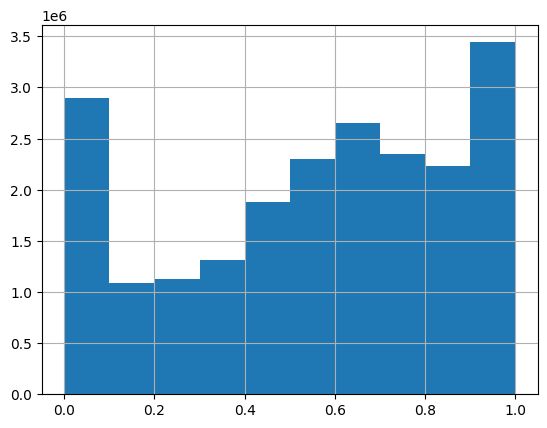

In [277]:
def get_entropies(X_hat):
    
    # Split again to get per-question probabilities
    split_sizes = [border_indices[0]] + \
                [border_indices[i+1] - border_indices[i] for i in range(len(border_indices)-1)] + \
                [q_df.shape[1] - border_indices[-1]]
    split_sizes = [item * (i+2) for i, item in enumerate(split_sizes)]
    split_tensors = torch.split(X_hat, split_sizes, dim=1)
    
    normalized_entropies = []
    for i, tensor in enumerate(split_tensors):
        options = 2 + i
        max_entropy = torch.log(torch.tensor(options))  # max entropy is log(n_options)
        
        reshaped = tensor.view(-1, tensor.shape[1]//options, options)
        entropy = -torch.sum(reshaped * torch.log(reshaped + 1e-10), dim=-1)
        normalized_entropies.append(entropy / max_entropy)
    
    return torch.cat(normalized_entropies, dim=1)
    
entropies = get_entropies(X_hat).flatten().detach().cpu()
missing_entropies = pd.Series(entropies[q_df.isna().values.flatten()])
missing_entropies.hist()